In [16]:
import xarray as xr
import pandas as pd

In [9]:
from myconfig import mypara
import numpy as np
from copy import deepcopy
import xarray as xr
import matplotlib as mpl
import matplotlib.pylab as plt
from matplotlib.ticker import MultipleLocator
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from my_tools import cal_ninoskill2, runmean
from func_for_prediction import func_pre
from torch.utils.data import IterableDataset
from torch.utils.data import Dataset
import torch
from Geoformer import Geoformer
import logging
import sys


def get_logger():
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    return logger

class make_dataset2():
    """
    online reading dataset
    """
    def __init__(self, mypara):
        self.mypara = mypara
        data_in = xr.open_dataset(mypara.adr_pretr)
        self.lev = data_in["lev"].values
        self.lat = data_in["lat"].values
        self.lon = data_in["lon"].values
        self.lev_range = mypara.lev_range
        self.lon_range = mypara.lon_range
        self.lat_range = mypara.lat_range
        self.input_length = mypara.input_length
        self.output_length = mypara.output_length
        self.all_group = mypara.all_group
        temp = data_in["temperatureNor"][
            :,
            :,
            mypara.lev_range[0] : mypara.lev_range[1],
            mypara.lat_range[0] : mypara.lat_range[1],
            mypara.lon_range[0] : mypara.lon_range[1],
        ].values
        temp = np.nan_to_num(temp)
        temp[abs(temp) > 999] = 0
        if mypara.needtauxy:
            print("loading tauxy...")
            taux = data_in["tauxNor"][
                :,
                :,
                mypara.lat_range[0] : mypara.lat_range[1],
                mypara.lon_range[0] : mypara.lon_range[1],
            ].values
            taux = np.nan_to_num(taux)
            taux[abs(taux) > 999] = 0
            tauy = data_in["tauyNor"][
                :,
                :,
                mypara.lat_range[0] : mypara.lat_range[1],
                mypara.lon_range[0] : mypara.lon_range[1],
            ].values
            tauy = np.nan_to_num(tauy)
            tauy[abs(tauy) > 999] = 0
            self.field_data = np.concatenate(
                (taux[:, :, None], tauy[:, :, None], temp), axis=2
            )
            del temp, taux, tauy
        else:
            self.field_data = temp
            del temp
        self.max_idx = self.field_data.shape[0] * (self.field_data.shape[1] - self.output_length - self.input_length)

    def __iter__(self):
        # st_min = self.input_length - 1
        # ed_max = self.field_data.shape[1] - self.output_length
        for model_num in np.arange(self.field_data.shape[0]):
            for indx in range(0,self.field_data.shape[1]-self.output_length-self.input_length):
                dataX = self.field_data[model_num, indx : indx + self.input_length]
                dataY = self.field_data[model_num, indx + self.input_length : indx + self.input_length + self.output_length]
                print(model_num, indx)
                yield dataX[np.newaxis,...], dataY[np.newaxis,...]


    def selectregion(self):
        return {
            "lon: {}E to {}E".format(
                self.lon[self.lon_range[0]],
                self.lon[self.lon_range[1] - 1],
            ),
            "lat: {}S to {}N".format(
                self.lat[self.lat_range[0]],
                self.lat[self.lat_range[1] - 1],
            ),
            "temp lev: {}m to {}m".format(
                self.lev[self.lev_range[0]], self.lev[self.lev_range[1] - 1]
            ),
        }


# log = get_logger()

mypara.adr_pretr = (
    "../data/CMIP6_separate_model_up150m_tauxy_Nor_1850_2014_kb.nc"
)

# i_file = "/glade/work/zilumeng/3D_trans/model/Geoformer_beforeTrans.pkl"
# print(i_file)
# log.info("loading model from {}".format(i_file))
# mymodel = Geoformer(mypara).to(mypara.device)
# mymodel.load_state_dict(torch.load(i_file))
# mymodel.eval()

# log.info("loading data from {}".format(mypara.adr_pretr))
dataset = make_dataset2(mypara)

loading tauxy...


In [15]:
var = dataset.field_data.std(axis=(1,3,4)) # (model, level)

KeyboardInterrupt: 

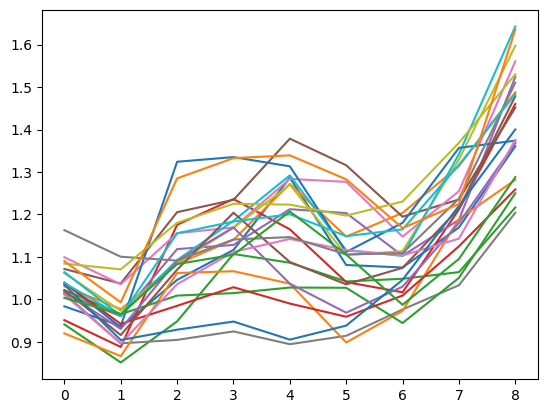

In [ ]:
for i in range(var.shape[0]):
    plt.plot(var[i])
np.save("model_level_var.npy", var)

In [3]:
np.array([[269,0],[278,7],[123,-6],[202,2],[210,-18],[172,1],[144,14],[124,-2]]).shape

(8, 2)

In [5]:
x.reshape(10).reshape((2,5))

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [4]:
data = xr.open_dataset("../data/CMIP6_separate_model_up150m_tauxy_Nor_1850_2014_kb.nc")
data

<xarray.Dataset>
Dimensions:         (n_model: 23, n_mon: 1980, lev: 8, lat: 51, lon: 179)
Coordinates:
  * lon             (lon) float64 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat             (lat) float64 -20.0 -19.0 -18.0 -17.0 ... 18.0 19.0 20.0
  * lev             (lev) float64 0.0 5.0 20.0 40.0 60.0 90.0 120.0 150.0
Dimensions without coordinates: n_model, n_mon
Data variables:
    temperatureNor  (n_model, n_mon, lev, lat, lon) float64 ...
    nino34          (n_model, n_mon) float64 ...
    tauxNor         (n_model, n_mon, lat, lon) float64 ...
    tauyNor         (n_model, n_mon, lat, lon) float64 ...
    stdtemp         (n_model, lev, lat, lon) float64 ...
    stdtaux         (n_model, lat, lon) float64 ...
    stdtauy         (n_model, lat, lon) float64 ...

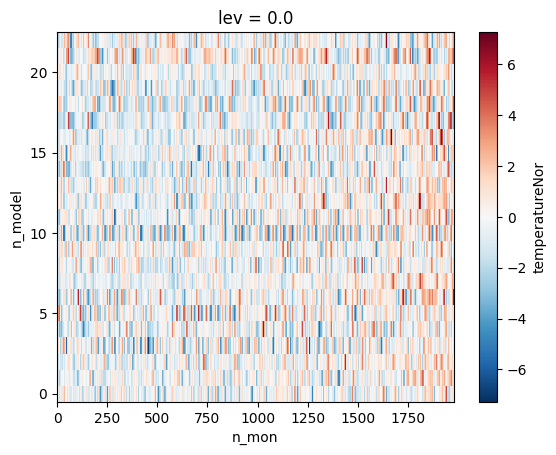

In [5]:
nino34 = data['temperatureNor'].loc[:,:,0,-5:5,190:240].mean(['lat','lon'])
nino34.plot()

In [8]:
times = pd.date_range('1850-01-01', '2014-12-31', freq='M')
times.shape

(1980,)

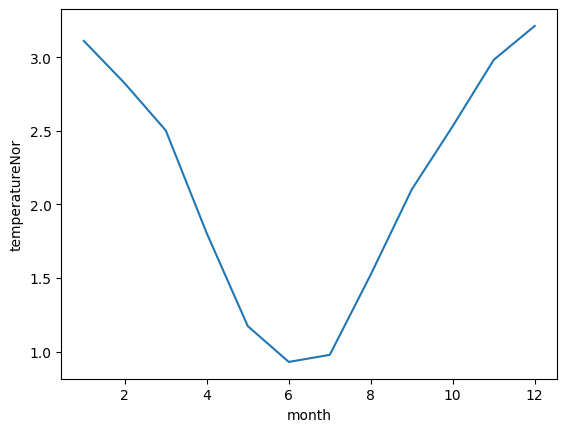

In [11]:
data1 = xr.DataArray(nino34[0], coords=[times], dims=['time'])
data1.groupby('time.month').var('time').plot()

In [2]:
import xarray as xr
data1 = xr.open_dataset("../data/GODAS_group_up150_temp_tauxy_1980_2021_kb.nc")
data1['stdtemp'].loc[5].mean()

<xarray.DataArray 'stdtemp' ()>
array(0.57352402)
Coordinates:
    lev      float64 5.0

In [19]:
data0 = xr.open_dataset("../data/GODAS_up150m_temp_nino_tauxy_1980_2021_kb.nc")
data0

<xarray.Dataset>
Dimensions:         (n_mon: 504, lev: 8, lat: 51, lon: 179)
Coordinates:
  * lon             (lon) float64 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat             (lat) float64 -20.0 -19.0 -18.0 -17.0 ... 18.0 19.0 20.0
  * lev             (lev) float64 0.0 5.0 20.0 40.0 60.0 90.0 120.0 150.0
Dimensions without coordinates: n_mon
Data variables:
    temperatureNor  (n_mon, lev, lat, lon) float64 ...
    nino34          (n_mon) float64 ...
    nino3           (n_mon) float64 ...
    nino4           (n_mon) float64 ...
    tauxNor         (n_mon, lat, lon) float64 ...
    tauyNor         (n_mon, lat, lon) float64 ...
    stdtemp         (lev, lat, lon) float64 ...
    stdtaux         (lat, lon) float64 ...
    stdtauy         (lat, lon) float64 ...

In [22]:
data0['temperatureNor'].var(['lat','lon','n_mon']), data0['tauxNor'].var(['lat','lon','n_mon']), data0['tauyNor'].var(['lat','lon','n_mon'])

(<xarray.DataArray 'temperatureNor' (lev: 8)>
 array([1.16453451, 1.16453451, 1.30670423, 1.45104827, 1.38649555,
        1.28114063, 1.28974571, 1.34734096])
 Coordinates:
   * lev      (lev) float64 0.0 5.0 20.0 40.0 60.0 90.0 120.0 150.0,
 <xarray.DataArray 'tauxNor' ()>
 array(1.10620295),
 <xarray.DataArray 'tauyNor' ()>
 array(1.07826316))

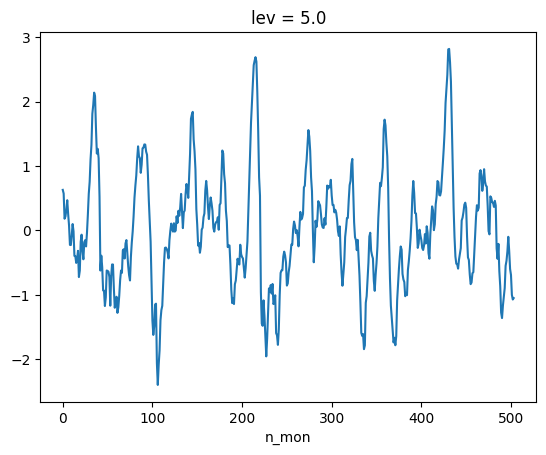

In [13]:
Nino34 = data0['temperatureNor'].loc[:,5,-5:5,190:240].mean(dim=['lat','lon']) * data0['stdtemp'].mean(dim=['lat','lon']).loc[5]
Nino34.plot()

In [2]:
path = "../data/CMIP6_separate_model_up150m_tauxy_Nor_1850_2014_kb.nc"
ds = xr.open_dataset(path)
ds

<xarray.Dataset>
Dimensions:         (n_model: 23, n_mon: 1980, lev: 8, lat: 51, lon: 179)
Coordinates:
  * lon             (lon) float64 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat             (lat) float64 -20.0 -19.0 -18.0 -17.0 ... 18.0 19.0 20.0
  * lev             (lev) float64 0.0 5.0 20.0 40.0 60.0 90.0 120.0 150.0
Dimensions without coordinates: n_model, n_mon
Data variables:
    temperatureNor  (n_model, n_mon, lev, lat, lon) float64 ...
    nino34          (n_model, n_mon) float64 ...
    tauxNor         (n_model, n_mon, lat, lon) float64 ...
    tauyNor         (n_model, n_mon, lat, lon) float64 ...
    stdtemp         (n_model, lev, lat, lon) float64 ...
    stdtaux         (n_model, lat, lon) float64 ...
    stdtauy         (n_model, lat, lon) float64 ...

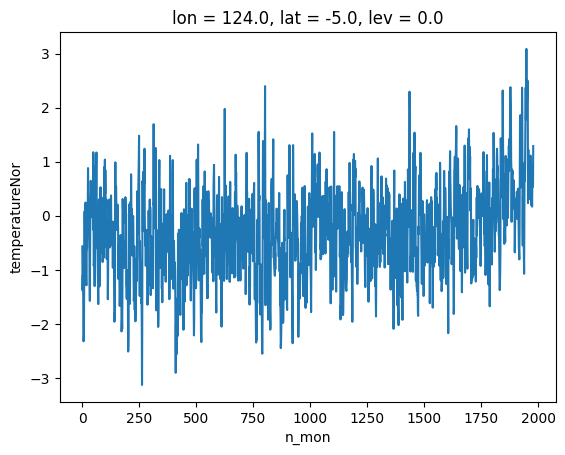

In [21]:
ds['temperatureNor'].loc[dict(lon=124,n_model=0,lev=0,lat=-5)].plot()

In [12]:
ds['temperatureNor'][:,:,-1].std()

<xarray.DataArray 'temperatureNor' ()>
array(1.21944377)
Coordinates:
    lev      float64 150.0

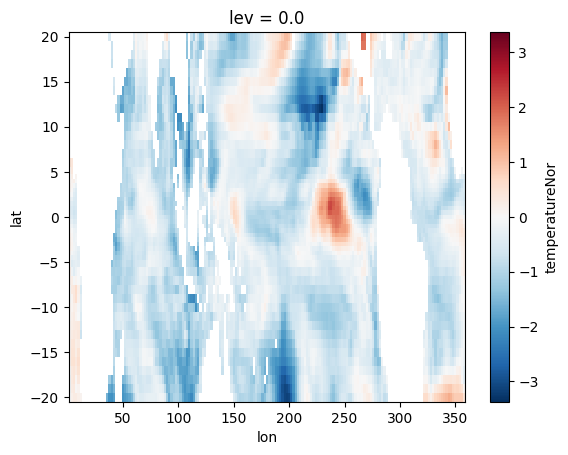

In [6]:
ds['temperatureNor'][0,0,0].plot()
# 参数: mypara.lev_range = (1, 8)
# mypara.lon_range = (45, 165)
# mypara.lat_range = (0, 51)

In [7]:
path1 = "/glade/work/zilumeng/3D_trans/data/SODA_ORAS_group_temp_tauxy_before1979_kb.nc"
ds1 = xr.open_dataset(path1)
ds1

<xarray.Dataset>
Dimensions:             (group: 1510, lookback: 12, lev: 8, lat: 51, lon: 179,
                         Tout: 20)
Coordinates:
  * lon                 (lon) float64 2.0 4.0 6.0 8.0 ... 354.0 356.0 358.0
  * lat                 (lat) float64 -20.0 -19.0 -18.0 -17.0 ... 18.0 19.0 20.0
  * lev                 (lev) float64 0.0 5.0 20.0 40.0 60.0 90.0 120.0 150.0
Dimensions without coordinates: group, lookback, Tout
Data variables:
    temperatureNor_in   (group, lookback, lev, lat, lon) float64 ...
    tauxNor_in          (group, lookback, lat, lon) float64 ...
    tauyNor_in          (group, lookback, lat, lon) float64 ...
    temperatureNor_out  (group, Tout, lev, lat, lon) float64 ...
    tauxNor_out         (group, Tout, lat, lon) float64 ...
    tauyNor_out         (group, Tout, lat, lon) float64 ...

In [1]:
[1,2,3][:10]

[1, 2, 3]

In [2]:
10 // 11

0

In [3]:
for i in range(0):
    print(i)

In [13]:
a = [1]*12
a[9:13]

[1, 1, 1]

In [26]:
import numpy as np
a = np.array([1,2,3])

ls1 = [a]
# del a
a[0] = 2
del a
ls1

[array([2, 2, 3])]